In [32]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/telco-customer-churn


# **Telecom Customer Churn Prediction**
Internship Task 02 — Digipex Solutions LLC, 2025 AI Program

**Objective**
The goal of this project is to build a machine learning pipeline that predicts whether a customer will churn (i.e., stop using the service) based on their personal demographics, account information, and service usage. This will help telecom companies identify at-risk customers and implement proactive retention strategies.

**Our Role in This Task**
As an AI intern, our responsibilities in this task include:

**Exploratory Data Analysis (EDA)**: Understanding customer behavior and churn trends through visualizations.

**Data Preprocessing**: Cleaning, encoding, scaling, and balancing the data to prepare it for machine learning.

**Model Development**: Training at least 3 different classification models to predict churn, including tree-based models like Random Forest or XGBoost.

**Model Interpretation**: Explaining how and why the model makes predictions using SHAP or LIME for business transparency.

**Business Recommendations**: Extracting actionable insights from the model to help business teams reduce churn.

**Client Insight Card**: Creating a one-slide visual summary with key findings and strategic suggestions.

**About the Dataset**
We are using the Telco Customer Churn Dataset from Kaggle, which contains information about 7,043 customers of a telecom company.

**Source**: Telco Customer Churn Dataset on Kaggle

**This dataset includes**:

**Customer Demographics**: Gender, senior citizen status, partner/dependent info

**Account Information:** Tenure, payment method, contract type

**Services Signed Up For:** Internet, phone, streaming services

**Churn Label:** Indicates whether the customer left or stayed

This real-world dataset allows us to simulate a business scenario where data-driven customer retention is a strategic focus.

In [33]:
import os
os.listdir(path)


['WA_Fn-UseC_-Telco-Customer-Churn.csv']

# Setup & Import Libraries

In [63]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For ML & Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay

# Optional: For imbalance handling
from imblearn.over_sampling import SMOTE

# Explainability
import shap


# Load the Dataset

In [35]:
# Load CSV (usually named 'WA_Fn-UseC_-Telco-Customer-Churn.csv')
df = pd.read_csv(os.path.join(path, 'WA_Fn-UseC_-Telco-Customer-Churn.csv'))

df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# **Dataset Overview**
The dataset we're working with is the Telco Customer Churn Dataset from Kaggle. It contains detailed information about 7,043 customers from a telecom company. Each row represents a unique customer and includes information on their personal demographics, services they use, account status, monthly charges, and whether they churned or not (i.e., left the service).

# Perform EDA (Exploratory Data Analysis)

Text(0.5, 1.0, 'Churn Distribution')

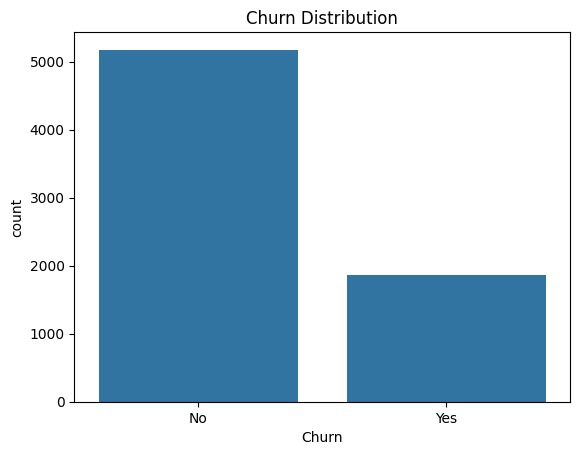

In [36]:
# Check class balance
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')


# **Tenure** **vs** **Churn** =

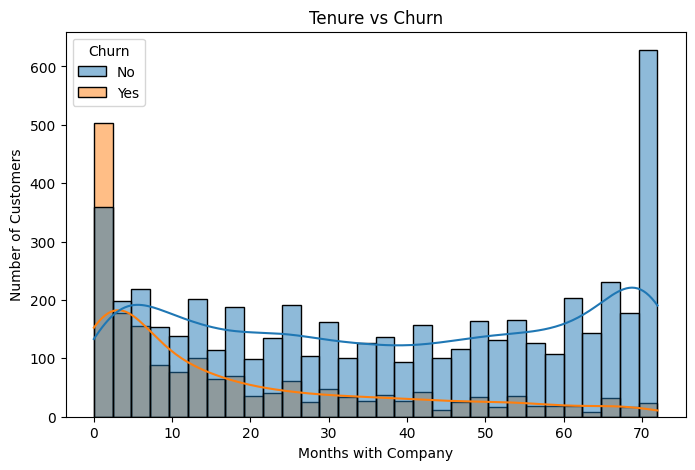

In [37]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='tenure', hue='Churn', bins=30, kde=True)
plt.title('Tenure vs Churn')
plt.xlabel('Months with Company')
plt.ylabel('Number of Customers')
plt.show()


# **Contract Type vs Churn**

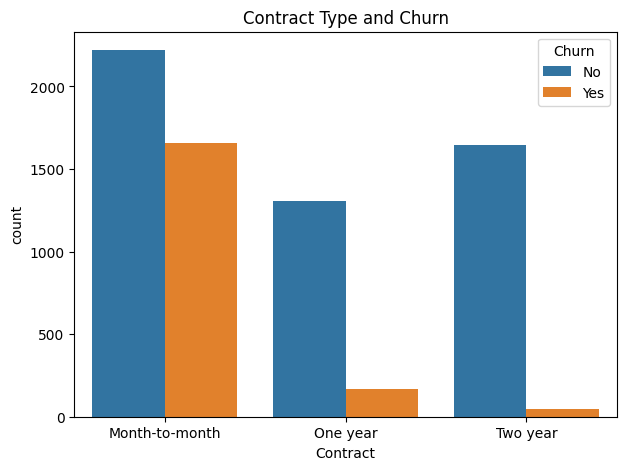

In [38]:
plt.figure(figsize=(7,5))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Contract Type and Churn')
plt.show()


# Monthly Charges vs **Churn**

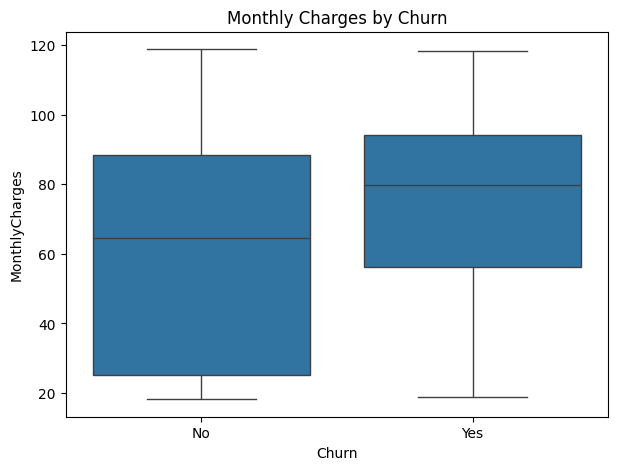

In [39]:
plt.figure(figsize=(7,5))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Monthly Charges by Churn')
plt.show()


# **Convert TotalCharges to Numeric**

In [40]:
# Check a few entries from Churn to see what's in there
print(df['Churn'].value_counts(dropna=False))


Churn
No     5174
Yes    1869
Name: count, dtype: int64


In [41]:
# Some entries in TotalCharges are blank strings → convert them
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows with missing values (from TotalCharges)
df.dropna(inplace=True)

df


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


# **Convert Target Column**

In [42]:
# Convert 'Churn' from Yes/No to 1/0
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

df


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,1


# **Encode Categorical Columns**

**Separate categorical & numerical columns:**

In [43]:
# Categorical columns
cat_cols = df.select_dtypes(include='object').columns.tolist()

# Binary encoding for Yes/No
binary_cols = [col for col in cat_cols if df[col].nunique() == 2]
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

df


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,NaN,0,1,0,1,0,No phone service,DSL,No,...,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,NaN,0,0,0,34,1,No,DSL,Yes,...,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,3668-QPYBK,NaN,0,0,0,2,1,No,DSL,Yes,...,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,NaN,0,0,0,45,0,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,NaN,0,0,0,2,1,No,Fiber optic,No,...,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,NaN,0,1,1,24,1,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,1,Mailed check,84.80,1990.50,0
7039,2234-XADUH,NaN,0,1,1,72,1,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,1,Credit card (automatic),103.20,7362.90,0
7040,4801-JZAZL,NaN,0,1,1,11,0,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,1,Electronic check,29.60,346.45,0
7041,8361-LTMKD,NaN,1,1,0,4,1,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,1,Mailed check,74.40,306.60,1


# **Identify and Map Only True Yes/No Columns**

In [60]:
# Re-load the original CSV just to fetch clean gender values
raw_df = pd.read_csv(os.path.join(path, 'WA_Fn-UseC_-Telco-Customer-Churn.csv'))

# Restore gender column to your processed DataFrame
df['gender'] = raw_df['gender']

# One-hot encode gender again
df = pd.get_dummies(df, columns=['gender'], drop_first=True)

# Final check
print("NaNs in df:", df.isnull().sum().sum())  # Should be 0








NaNs in df: 0


,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,customerID_0003-MKNFE,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,gender_Male
0,0,1,0,-1.280248,0,1,-1.161694,-0.994194,0,False,...,False,False,False,False,False,False,True,False,False,False
1,0,0,0,0.064303,1,0,-0.260878,-0.173740,0,False,...,False,False,False,True,False,False,False,True,True,True
2,0,0,0,-1.239504,1,1,-0.363923,-0.959649,1,False,...,False,False,False,False,False,False,False,True,True,True
3,0,0,0,0.512486,0,0,-0.747850,-0.195248,0,False,...,False,False,False,True,False,False,False,False,True,True
4,0,0,0,-1.239504,1,1,0.196178,-0.940457,1,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,1,1,-0.343137,1,1,0.664868,-0.129180,0,False,...,True,False,True,True,False,False,False,True,True,True
7039,0,1,1,1.612573,1,1,1.276493,2.241056,0,False,...,True,False,True,True,False,True,False,False,False,False
7040,0,1,1,-0.872808,0,1,-1.170004,-0.854514,0,False,...,False,False,False,False,False,False,True,False,False,False
7041,1,1,0,-1.158016,1,1,0.319168,-0.872095,1,False,...,False,False,False,False,False,False,False,True,True,True


In [58]:
df


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,NaN,0,1,0,-1.280248,0,1,-1.161694,-0.994194,0,...,False,False,False,False,False,False,False,False,True,False
1,NaN,0,0,0,0.064303,1,0,-0.260878,-0.173740,0,...,False,False,False,False,False,True,False,False,False,True
2,NaN,0,0,0,-1.239504,1,1,-0.363923,-0.959649,1,...,False,False,False,False,False,False,False,False,False,True
3,NaN,0,0,0,0.512486,0,0,-0.747850,-0.195248,0,...,True,False,False,False,False,True,False,False,False,False
4,NaN,0,0,0,-1.239504,1,1,0.196178,-0.940457,1,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,NaN,0,1,1,-0.343137,1,1,0.664868,-0.129180,0,...,True,False,True,False,True,True,False,False,False,True
7039,NaN,0,1,1,1.612573,1,1,1.276493,2.241056,0,...,False,False,True,False,True,True,False,True,False,False
7040,NaN,0,1,1,-0.872808,0,1,-1.170004,-0.854514,0,...,False,False,False,False,False,False,False,False,True,False
7041,NaN,1,1,0,-1.158016,1,1,0.319168,-0.872095,1,...,False,False,False,False,False,False,False,False,False,True


**One-Hot Encoding for remaining **

In [44]:
# One-hot encode other categorical columns (like Contract, InternetService, etc.)
df = pd.get_dummies(df, drop_first=True)


# **Scale Numeric** **Columns**

In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[num_cols] = scaler.fit_transform(df[num_cols])

df


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,NaN,0,1,0,-1.280248,0,1,-1.161694,-0.994194,0,...,False,False,False,False,False,False,False,False,True,False
1,NaN,0,0,0,0.064303,1,0,-0.260878,-0.173740,0,...,False,False,False,False,False,True,False,False,False,True
2,NaN,0,0,0,-1.239504,1,1,-0.363923,-0.959649,1,...,False,False,False,False,False,False,False,False,False,True
3,NaN,0,0,0,0.512486,0,0,-0.747850,-0.195248,0,...,True,False,False,False,False,True,False,False,False,False
4,NaN,0,0,0,-1.239504,1,1,0.196178,-0.940457,1,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,NaN,0,1,1,-0.343137,1,1,0.664868,-0.129180,0,...,True,False,True,False,True,True,False,False,False,True
7039,NaN,0,1,1,1.612573,1,1,1.276493,2.241056,0,...,False,False,True,False,True,True,False,True,False,False
7040,NaN,0,1,1,-0.872808,0,1,-1.170004,-0.854514,0,...,False,False,False,False,False,False,False,False,True,False
7041,NaN,1,1,0,-1.158016,1,1,0.319168,-0.872095,1,...,False,False,False,False,False,False,False,False,False,True


# **Train-Test Split**


In [46]:
from sklearn.model_selection import train_test_split

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [47]:
print(df['Churn'].unique())


[0 1]


In [48]:
# Check for missing values
print(X_train.isnull().sum())


gender                                   5625
SeniorCitizen                               0
Partner                                     0
Dependents                                  0
tenure                                      0
                                         ... 
Contract_One year                           0
Contract_Two year                           0
PaymentMethod_Credit card (automatic)       0
PaymentMethod_Electronic check              0
PaymentMethod_Mailed check                  0
Length: 7061, dtype: int64


In [49]:
# Drop rows with missing gender
X_train = X_train.dropna(subset=['gender'])
y_train = y_train[X_train.index]  # Keep target aligned


In [50]:
print('gender' in X_train.columns)


True


In [51]:
print(X_train['gender'].value_counts(dropna=False))


Series([], Name: count, dtype: int64)


In [52]:
# Define features and target again
X = df.drop('Churn', axis=1)
y = df['Churn']


In [53]:
# Confirm there are no missing values before split
print("NaNs in X:", X.isnull().sum().sum())
print("NaNs in y:", y.isnull().sum())


NaNs in X: 7032
NaNs in y: 0


## **Run This Before Splitting:**

In [54]:
# Step 1: Prepare feature and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Step 2: Impute all NaNs with column-wise mode (safe for mixed data)
X = X.fillna(X.mode().iloc[0])

# Step 3: Confirm NaNs are gone
print("NaNs in X after fill:", X.isnull().sum().sum())  # Should be 0


NaNs in X after fill: 7032


# **Handle Class Imbalance (SMOTE)**

In [61]:
X = df.drop('Churn', axis=1)
y = df['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)



## ** Convert DataFrame to Numeric**

In [69]:
# Convert to NumPy arrays (this avoids all Pandas dtype issues)
X_train_sm_np = X_train_sm.to_numpy()
X_test_np = X_test.to_numpy()




# **Code for All 3 Models**


 Training Logistic Regression...
 Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1033
           1       0.55      0.63      0.59       374

    accuracy                           0.77      1407
   macro avg       0.71      0.72      0.71      1407
weighted avg       0.78      0.77      0.77      1407


 Training Random Forest...
 Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1033
           1       0.58      0.56      0.57       374

    accuracy                           0.78      1407
   macro avg       0.71      0.71      0.71      1407
weighted avg       0.77      0.78      0.77      1407


 Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:54:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.88      0.77      0.82      1033
           1       0.52      0.70      0.60       374

    accuracy                           0.75      1407
   macro avg       0.70      0.73      0.71      1407
weighted avg       0.78      0.75      0.76      1407



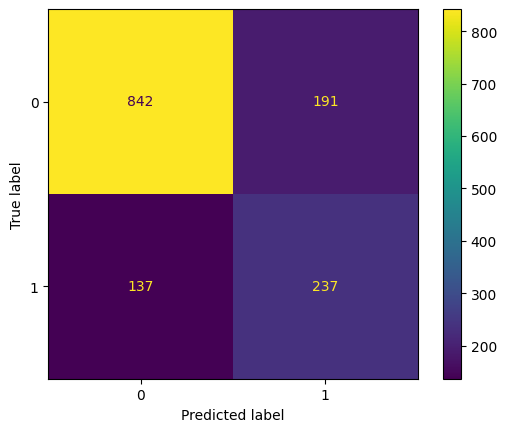

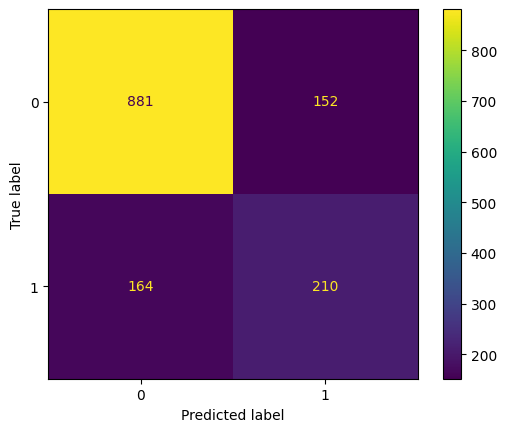

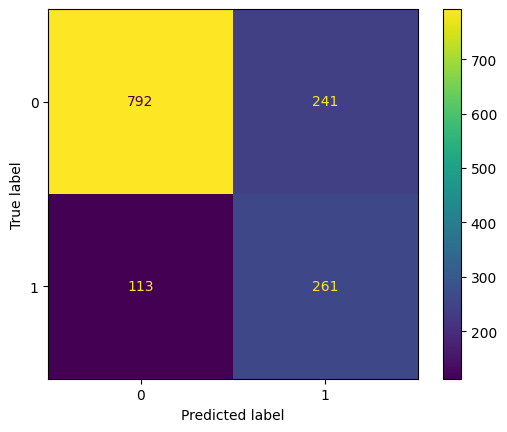

In [72]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

for name, model in models.items():
    print(f"\n Training {name}...")

    if name == 'XGBoost':
        model.fit(X_train_sm_np, y_train_sm)
        y_pred = model.predict(X_test_np)
    else:
        model.fit(X_train_sm, y_train_sm)
        y_pred = model.predict(X_test)

    print(f" Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


# **SHAP: Model Explainability**

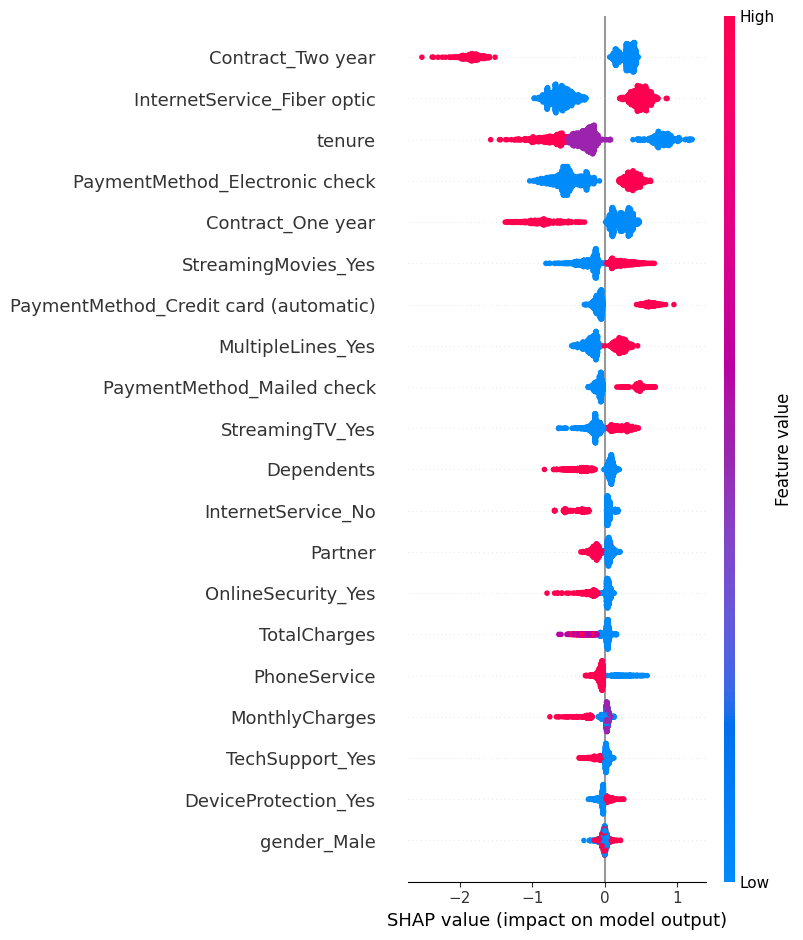

In [71]:
import shap

# Initialize SHAP for XGBoost
explainer = shap.TreeExplainer(models['XGBoost'])
shap_values = explainer.shap_values(X_test_np)

# SHAP summary plot — top features driving churn
shap.summary_plot(shap_values, X_test_np, feature_names=X_test.columns)
